# Simple Neural Network

## Introduction

This notebook focuses on classifying handwritten digits with the MNIST data set.

Here, models were created for binary classification. Specifically, data of 0 and 6 were used due to the two digits being relatively similar to each other.

Some elements are based on Ng (2017), with modifications.

In [1]:
# loads packages

import mnist
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# loads data sets

dat_train_labels=mnist.train_labels()
dat_train_images=mnist.train_images()

dat_test_labels=mnist.test_labels()
dat_test_images=mnist.test_images()

In [3]:
# creates data sets for binary classification (i.e. only 0 and 6)

dat_train_binary_labels=dat_train_labels[np.logical_or(dat_train_labels==0, dat_train_labels==6)]
dat_train_binary_images=dat_train_images[np.logical_or(dat_train_labels==0, dat_train_labels==6)]

dat_test_binary_labels=dat_test_labels[np.logical_or(dat_test_labels==0, dat_test_labels==6)]
dat_test_binary_images=dat_test_images[np.logical_or(dat_test_labels==0, dat_test_labels==6)]

## Data

The train set contains 11841 images, 5923 images are 0 and 5918 are 6.

The test set contains 1938 images, 980 images are 0 and 958 are 6.

Each image has 28 $\times$ 28 pixels, each of which is associated with a grayscale value (0 is completely black, 255 is completely white).

Below are two examples.

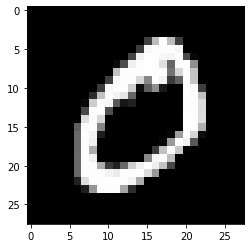

In [4]:
plt.imshow(dat_train_binary_images[0], cmap="Greys_r")

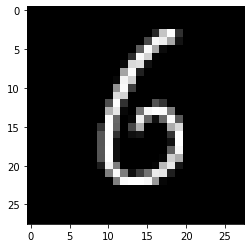

In [5]:
plt.imshow(dat_train_binary_images[2], cmap="Greys_r")

### Reshaping

Data sets containing the images were in a three-dimensional format (samples $\times$ rows of pixels $\times$ columns of pixels), and therefore were reshaped into a two-dimensional (total pixels $\times$ samples).

In [6]:
def func_reshape(data):
    
    data_reshaped=data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
    
    data_reshaped=data_reshaped.T
    
    return data_reshaped

In [7]:
dat_train_binary_images=func_reshape(dat_train_binary_images)
dat_test_binary_images=func_reshape(dat_test_binary_images)

In [8]:
dat_train_binary_images.shape

(784, 11841)

In [9]:
dat_test_binary_images.shape

(784, 1938)

### Standardisation

The pixel data were further standardised.

In [10]:
dat_train_binary_images=dat_train_binary_images/255
dat_test_binary_images=dat_test_binary_images/255

### Recoding

One final step in data preparation was to make the labels into 0 and 1.

For the sake of convenience, all 6 were recoded as 1. In other words, the task became whether a handwritten digit was 6 as opposed to 0.

In [11]:
dat_train_binary_labels[dat_train_binary_labels==6]=1
dat_test_binary_labels[dat_test_binary_labels==6]=1

In [12]:
dat_train_binary_labels.shape

(11841,)

In [13]:
dat_test_binary_labels.shape

(1938,)

## Model 1 (Logistic Regression)

A logistic regression can be viewed as the simplest neural network possible for a binary classification, that is, a one-layer neural network.

The input layer has $\mathbf{X}$ which is a matrix of input greyscale values (total pixels $\times$ samples).

The output layer has $\mathbf{W}$ which is a vector of weights (total pixels $\times$ 1), $b$ which is a scalar bias term, and $\mathbf{A}$ which is a vector of predicted label (1 $\times$ samples).

### Forward Propagation

$$
\mathbf{A} = \sigma(\mathbf{W}^\intercal \mathbf{X} + b)
$$

$\sigma$ is the sigmoid function which is the inverse of the logit function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Given $m$ sample, the cost function $J$ is:

$$
J =
-\frac{1}{m} \sum^m_{i=1} [y^{(i)} \log(a^{(i)}) + (1 - y^{(i)}) \log(1 - a^{(i)})]
$$

where $i$ is the sample index.

Cost function $J$ is the normalised model errors across all samples.

The unnormalised cost function, $mJ$,  is known as deviance ($\chi^2$) in traditional statistics. $-mJ$ is simply the log likelihood of $m$ independent Bernoulli trials.

In [14]:
def sigma(z):
    
    return 1/(1+np.exp(-z))

In [15]:
def func_forward_prop_model_1(Y, X, W, b, m):
    
    A=sigma(W.T @ X + b)
    
    J= (-1/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    return A, J

### Back Propagation

The gradient descent of the parameters is as follows:

$$
\frac{\partial J}{\partial \mathbf{W}} =
\frac{1}{m} \mathbf{X} (\mathbf{A} - \mathbf{Y})^\intercal
$$


$$
\frac{\partial J}{\partial b} =
\frac{1}{m} \sum^m_{i=1} (a^{(i)} - y^{(i)})
$$

The two parameters are updated as follows:

$$
\mathbf{W} =
\mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} 
$$

$$
b = b - \alpha \frac{\partial J}{\partial b}
$$

where $\alpha$ is the learning rate.

In [16]:
def func_back_prop_model_1(Y, X, W, b, m, A, alpha):
    
    dW=(X @ (A-Y).T)/m
    
    db=(np.sum(A-Y))/m
    
    W_new=W-alpha*dW
    
    b_new=b-alpha*db
    
    return W_new, b_new

### Running the Model

First, $\mathbf{W}$ and $b$ were initialised. $\mathbf{W}$ is a vector of 0 while $b$ is just 0.

Second, $\alpha$ was set to 0.01.

Then the model was run for 100 iterations, in each of which predictions were made for both the train and test sets using the current $\mathbf{W}$ and $b$ values, and prediction accuracy was calculated.

In [17]:
def func_forward_back_prop_model_1(Y, X, W, b, alpha):
    
    m=Y.shape[0] # number of samples
    
    A, J=func_forward_prop_model_1(Y, X, W, b, m)
    
    W_new, b_new=func_back_prop_model_1(Y, X, W, b, m, A, alpha)
    
    return J, W_new, b_new

In [18]:
def func_prediction_model_1(Y, X, W_new, b_new):
    
    A_predict=sigma(W_new.T @ X + b_new)  
    A_predict=np.where(A_predict < .5, 0, 1)
    
    accuracy=Y.shape[0]-np.sum(np.abs(A_predict - Y)) # total - wrong predictions
    accuracy=accuracy/Y.shape[0] # normalised
    
    return accuracy

In [19]:
alpha=.01

chain_W=[np.zeros((dat_train_binary_images.shape[0], 1))] # each W is the weights in an iteration
chain_b=[0] # each b is the bias in an iteration

chain_J=[]

chain_accuracy_train=[]
chain_accuracy_test=[]

In [20]:
for i in range(100):
    
    J, W_new, b_new=func_forward_back_prop_model_1(dat_train_binary_labels, dat_train_binary_images, chain_W[i], chain_b[i], alpha)
    
    chain_J.append(J)
    chain_W.append(W_new)
    chain_b.append(b_new)
    
    accuracy_train=func_prediction_model_1(dat_train_binary_labels, dat_train_binary_images, W_new, b_new)
    chain_accuracy_train.append(accuracy_train)
    
    accuracy_test=func_prediction_model_1(dat_test_binary_labels, dat_test_binary_images, W_new, b_new)
    chain_accuracy_test.append(accuracy_test)

### Results

The results suggested that the task is probably too simple.

The train set was able to achieve a 91% accuracy right at the beginning and 97% after 100 iterations. While an accuracy close to 100% is not uncommon in training a neural network, the test set was also able to achieve a 97% accuracy with this one-layer model.

In [21]:
chain_accuracy_train[0:5] # train set, 5 iterations

[0.9148720547251077,
 0.9224727641246516,
 0.927033189764378,
 0.9317625200574275,
 0.9369141119837852]

In [22]:
chain_accuracy_train[94:99] # train set, 100 iterations

[0.969850519381809,
 0.969850519381809,
 0.969850519381809,
 0.9700194240351322,
 0.9701883286884554]

In [23]:
chain_accuracy_test[0:5] # test set, 5 iterations

[0.8978328173374613,
 0.9066047471620227,
 0.9143446852425181,
 0.9231166150670794,
 0.9277605779153767]

In [24]:
chain_accuracy_test[94:99] # test set, 100 iterations

[0.9700722394220846,
 0.9705882352941176,
 0.9705882352941176,
 0.9705882352941176,
 0.9705882352941176]

## Model 2 (L-layer Neural Network)

The input layer ($l=0$) has $\mathbf{X}$ which is a matrix of input greyscale values (number of units in layer 0 $\times$ samples).

Each layer $l$ has $\mathbf{W}^{[l]}$ which is a matrix of weights (number of units in layer $l$ $\times$ numer of units in layer $l-1$), $\mathbf{b}^{[l]}$ which is a vector of bias terms (number of units in layer $l$ $\times$ 1), and $\mathbf{A}^{[l]}$ which is a matrix of output (numer of units in layer $l$ $\times$ samples).

### Forward Propagation

The activation of layer $l$ is as follows:

$$
\mathbf{A}^{[l]} =
g^{[l]}(\mathbf{W}^{[l]} \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]})
$$

where $g^{[l]}$ is the activation function of layer $l$.

$\mathbf{A}^{[0]}$ is the input $\mathbf{X}$. For the final layer $l=L$, $\mathbf{A}^{[L]}$ is the predicted value $\hat{\mathbf{Y}}$.

#### Activation Functions

For all layers besides the last one, $l \neq L$, Rectified Linear Units (ReLU) was used:

$$
f(z) =
\text{max}(0, z) = \begin{cases}
z, z>0 \\
0, z \leq 0
\end{cases}
$$

For the final layer $l=L$, the sigmoid function was used:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [25]:
def relu(z):
    
    return np.maximum(0, z)

In [26]:
def func_forward_prop_model_2(n_layers, X, W, b):
    
    A=[]
    
    A.append(relu(W[0] @ X + b[0])) # first layer
    
    if (n_layers>2): # if there are more than two layers, all layers between 1 and L-1
    
        for l in range(1, n_layers-1): # remember the indices is exclusive of the last digit
    
            A.append(relu(W[l] @ A[l-1] + b[l]))
        
    A.append(sigma(W[n_layers-1] @ A[n_layers-2] + b[n_layers-1])) # the final layer L
    
    return A

### Back Propagation

Back propagation initiated with:

$$
d \mathbf{A}^{[L]} = (-\frac{y^{(1)}}{a^{(1)}} + \frac{(1-y^{(1)})}{(1-a^{(1)})} ... -\frac{y^{(m)}}{a^{(m)}} + \frac{(1-y^{(m)})}{(1-a^{(m)})})
$$

With $d \mathbf{A}^{[L]}$, the gradient descent of the two parameters in each layer could be calculated:

$$
d \mathbf{Z}^{[l]} = 
d \mathbf{A}^{[l]} \circ g^{[l]'}(\mathbf{W}^{[l]} \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]})
$$

$$
d \mathbf{W}^{[l]} =
\frac{1}{m} d \mathbf{Z}^{[l]} \cdot \mathbf{A}^{[l-1] \intercal}
$$

$$
d \mathbf{b}^{[l]} =
\frac{1}{m} \sum^m_{i=1} d \mathbf{Z}^{[l](i)}
$$

$$
d \mathbf{A}^{[l-1]} =
\mathbf{W}^{[l] \intercal} d \mathbf{Z}^{[l]}
$$

Finally, the two parameters in each layer were updated using the same formula as above:

$$
\theta^{[l]} := \theta^{[l]} - \alpha d \theta^{[l]}
$$

where $\alpha$ is the learning rate.

In [27]:
def relu_derivative(z):
    
    return np.where(z>0, 1, 0)

In [28]:
def sigma_derivative(z):
    
    return (sigma(z) * (1-sigma(z)))

In [29]:
def func_back_prop_model_2(n_layers, Y, X, A, W, b, alpha):
    
    dA=[]
    dZ=[]
    dW=[]
    db=[]
    
    m=Y.shape[0] # number of samples
    
    for l in range(n_layers):
        
        dA.append([])
        dZ.append([])
        dW.append([])
        db.append([])
        
    # the final layer L
        
    dA[n_layers-1]= -(np.divide(Y, A[n_layers-1]) - np.divide(1-Y, 1-A[n_layers-1]))
    
    dZ[n_layers-1]=dA[n_layers-1] * sigma_derivative(W[n_layers-1] @ A[n_layers-2] + b[n_layers-1])
    
    dW[n_layers-1]=(dZ[n_layers-1] @ A[n_layers-2].T)/m
    
    db[n_layers-1]=np.sum(dZ[n_layers-1], axis=1, keepdims=True)/m
    
    for l in range(n_layers-2, 0, -1):
        
        dA[l]=W[l+1].T @ dZ[l+1]
        
        dZ[l]=dA[l] * relu_derivative(W[l] @ A[l-1] + b[l])
        
        dW[l]=(dZ[l] @ A[l-1].T)/m
        
        db[l]=np.sum(dZ[l], axis=1, keepdims=True)/m
    
    # the first layer
    
    dA[0]=W[1].T @ dZ[1]
        
    dZ[0]=dA[0] * relu_derivative(W[0] @ X + b[0])
        
    dW[0]=(dZ[0] @ X.T)/m
        
    db[0]=np.sum(dZ[0], axis=1, keepdims=True)/m
    
    for l in range(n_layers):
        
        W[l]=W[l]-alpha * dW[l]
        
        b[l]=b[l]-alpha * db[l]
    
    return W, b

### Running the Models

The learning rate $\alpha$ was set to 0.01 since this value worked well in the previous logistic regression model.

In [30]:
alpha=.01

In [31]:
def func_initalisation_model_2(layer_dimensions):
    
    np.random.seed(42)
    
    n_layers=len(layer_dimensions)-1 # excludes the input layer

    chain_W=[[]] # each W is the weights for all layers in an iteration
    chain_b=[[]] # each b is the biases for all layers in an iteration

    for l in range(n_layers-1): # layers 1 to L-1
    
        chain_W[0].append(np.random.randn(layer_dimensions[l+1], layer_dimensions[l])*0.01)
        chain_b[0].append(np.zeros((layer_dimensions[l+1], 1)))
    
    # the following is the final layer L

    chain_W[0].append(np.random.randn(1, layer_dimensions[n_layers-1])*0.01)
    chain_b[0].append(0)
    
    return n_layers, chain_W, chain_b

In [32]:
def func_forward_back_prop_model_2(n_layers, Y, X, W, b, alpha):
    
    A=func_forward_prop_model_2(n_layers, X, W, b)
    
    W_new, b_new=func_back_prop_model_2(n_layers, Y, X, A, W, b, alpha)
    
    return W_new, b_new

In [33]:
def func_prediction_model_2(n_layers, Y, X, W_new, b_new):
    
    A=[]
    
    A.append(relu(W_new[0] @ X + b_new[0])) # first layer
    
    if (n_layers>2): # if there are more than two layers, all layers between 1 and L-1
    
        for l in range(1, n_layers-1): # remember the indices is exclusive of the last digit
    
            A.append(relu(W_new[l] @ A[l-1] + b_new[l]))
        
    A.append(sigma(W_new[n_layers-1] @ A[n_layers-2] + b_new[n_layers-1])) # the final layer L
    
    A_predict=A[n_layers-1]
    A_predict=np.where(A_predict < .5, 0, 1)
    
    accuracy=Y.shape[0]-np.sum(np.abs(A_predict - Y)) # total - wrong predictions
    accuracy=accuracy/Y.shape[0] # normalised
    
    return accuracy

#### 2-layer 10-unit Shallow Network

Results showed that this model performed worse than the logistic regression model after 100 iterations.

Increasing the number of iterations could improve performance, but it was still at below 90% accuracy.

In [34]:
n_layers_v1, chain_W_v1, chain_b_v1=func_initalisation_model_2([dat_train_binary_images.shape[0], 10, 1]) # includes the input layer

In [35]:
def func_running_model_2(iterations, n_layers, Y_train, X_train, Y_test, X_test, chain_W, chain_b, alpha):
    
    chain_accuracy_train=[]
    chain_accuracy_test=[]

    for i in range(iterations):
    
        W_new, b_new=func_forward_back_prop_model_2(n_layers, Y_train, X_train, chain_W[i], chain_b[i], alpha)
    
        chain_W.append(W_new)
        chain_b.append(b_new)
    
        accuracy_train=func_prediction_model_2(n_layers, Y_train, X_train, W_new, b_new)
        chain_accuracy_train.append(accuracy_train)
    
        accuracy_test=func_prediction_model_2(n_layers, Y_test, X_test, W_new, b_new)
        chain_accuracy_test.append(accuracy_test)
        
    return chain_accuracy_train, chain_accuracy_test

In [36]:
chain_accuracy_train_v1, chain_accuracy_test_v1=func_running_model_2(100, n_layers_v1, dat_train_binary_labels, dat_train_binary_images, dat_test_binary_labels, dat_test_binary_images, chain_W_v1, chain_b_v1, alpha)

In [37]:
chain_accuracy_train_v1[94:99]

[0.7894603496326323,
 0.7908960391858796,
 0.7925006333924499,
 0.793767418292374,
 0.7944430369056668]

In [38]:
chain_accuracy_test_v1[94:99]

[0.7502579979360166,
 0.7497420020639834,
 0.7512899896800825,
 0.7523219814241486,
 0.7543859649122807]

#### 5-layer 10-unit Shallow Network

Results showed that increasing the number of layers but not the number of hidden units actually reduced performance. The accuracy of this model was identical to blind guesses.

Note that increasing the number of iterations did *not* improve performance.

In [39]:
n_layers_v2, chain_W_v2, chain_b_v2=func_initalisation_model_2([dat_train_binary_images.shape[0], 10, 10, 10, 10, 1]) # includes the input layer

In [40]:
chain_accuracy_train_v2, chain_accuracy_test_v2=func_running_model_2(100, n_layers_v2, dat_train_binary_labels, dat_train_binary_images, dat_test_binary_labels, dat_test_binary_images, chain_W_v2, chain_b_v2, alpha)

In [41]:
chain_accuracy_train_v2[94:99]

[0.500211130816654,
 0.500211130816654,
 0.500211130816654,
 0.500211130816654,
 0.500211130816654]

In [42]:
chain_accuracy_test_v2[94:99]

[0.5056759545923633,
 0.5056759545923633,
 0.5056759545923633,
 0.5056759545923633,
 0.5056759545923633]

#### 2-layer 700-unit Deep Network

Results were acceptable at 95% accuracy after 100 iterations and 96% after 200 iterations.

In [43]:
n_layers_v3, chain_W_v3, chain_b_v3=func_initalisation_model_2([dat_train_binary_images.shape[0], 700, 1]) # includes the input layer

In [44]:
# this took a while to run, so the results were saved on disk instead

# chain_accuracy_train_v3, chain_accuracy_test_v3=func_running_model_2(200, n_layers_v3, dat_train_binary_labels, dat_train_binary_images, dat_test_binary_labels, dat_test_binary_images, chain_W_v3, chain_b_v3, alpha)

# file_NN_2_layers_700_units=open("Data/Objects_Neural_Network_Accuracies_2_Layers_700_Units.obj", "wb") 
# pickle.dump([chain_accuracy_train_v3, chain_accuracy_test_v3], file_NN_2_layers_700_units)

In [45]:
file_NN_2_layers_700_units=open("Data/Objects_Neural_Network_Accuracies_2_Layers_700_Units.obj", "rb")
chain_accuracy_v3=pickle.load(file_NN_2_layers_700_units)

In [46]:
chain_accuracy_v3[0][94:99] # train set, 100 iterations

[0.9524533400895194,
 0.9527911493961658,
 0.9532134110294739,
 0.9534667680094586,
 0.9536356726627818]

In [47]:
chain_accuracy_v3[0][194:199] # train set, 200 iterations

[0.9668102356219914,
 0.966894687948653,
 0.9669791402753146,
 0.9669791402753146,
 0.9669791402753146]

In [48]:
chain_accuracy_v3[1][194:199] # test set, 200 iterations

[0.9659442724458205,
 0.9659442724458205,
 0.9664602683178535,
 0.9664602683178535,
 0.9664602683178535]

#### 2-layer 5000-unit Deep Network

Accuracy reached 96% after 100 iterations and marginally increased to 97% after 200 iterations, the latter of which was slightly above that of the logistic regression model.

In [49]:
n_layers_v4, chain_W_v4, chain_b_v4=func_initalisation_model_2([dat_train_binary_images.shape[0], 5000, 1]) # includes the input layer

In [50]:
# this took a while to run, so the results were saved on disk instead

# chain_accuracy_train_v4, chain_accuracy_test_v4=func_running_model_2(200, n_layers_v4, dat_train_binary_labels, dat_train_binary_images, dat_test_binary_labels, dat_test_binary_images, chain_W_v4, chain_b_v4, alpha)

# file_NN_2_layers_5000_units=open("Data/Objects_Neural_Network_Accuracies_2_Layers_5000_Units.obj", "wb") 
# pickle.dump([chain_accuracy_train_v4, chain_accuracy_test_v4], file_NN_2_layers_5000_units)

In [51]:
file_NN_2_layers_5000_units=open("Data/Objects_Neural_Network_Accuracies_2_Layers_5000_Units.obj", "rb")
chain_accuracy_v4=pickle.load(file_NN_2_layers_5000_units)

In [52]:
chain_accuracy_v4[0][94:99] # train set, 100 iterations

[0.9668102356219914,
 0.9668102356219914,
 0.9670635926019762,
 0.9672324972552994,
 0.967316949581961]

In [53]:
chain_accuracy_v4[0][194:199] # train set, 200 iterations

[0.9733130647749345,
 0.9733975171015962,
 0.9733975171015962,
 0.9733975171015962,
 0.9733975171015962]

In [54]:
chain_accuracy_v4[1][194:199] # test set, 200 iterations

[0.9757481940144479,
 0.9757481940144479,
 0.9757481940144479,
 0.9757481940144479,
 0.9757481940144479]

#### 4-layer 700-unit Deep Network

This model required much more iterations to train.

The accuracy was at only 62% after 100 iterations, and reached 93% after 500 iterations.

In [55]:
n_layers_v5, chain_W_v5, chain_b_v5=func_initalisation_model_2([dat_train_binary_images.shape[0], 700, 700, 700, 1]) # includes the input layer

In [56]:
# this took a while to run, so the results were saved on disk instead

# chain_accuracy_train_v5, chain_accuracy_test_v5=func_running_model_2(500, n_layers_v5, dat_train_binary_labels, dat_train_binary_images, dat_test_binary_labels, dat_test_binary_images, chain_W_v5, chain_b_v5, alpha)

# file_NN_4_layers_700_units=open("Data/Objects_Neural_Network_Accuracies_4_Layers_700_Units.obj", "wb") 
# pickle.dump([chain_accuracy_train_v5, chain_accuracy_test_v5], file_NN_4_layers_700_units)

In [57]:
file_NN_4_layers_700_units=open("Data/Objects_Neural_Network_Accuracies_4_Layers_700_Units.obj", "rb")
chain_accuracy_v5=pickle.load(file_NN_4_layers_700_units)

In [58]:
chain_accuracy_v5[0][94:99] # train set, 100 iterations

[0.6069588717169158,
 0.609239084536779,
 0.6119415589899502,
 0.615150747403091,
 0.6180221265095853]

In [59]:
chain_accuracy_v5[0][494:499] # train set, 500 iterations

[0.9385187061903555,
 0.9386031585170171,
 0.9386876108436787,
 0.9386876108436787,
 0.9387720631703403]

In [60]:
chain_accuracy_v5[1][494:499] # test set, 500 iterations

[0.9298245614035088,
 0.9303405572755418,
 0.9308565531475749,
 0.9308565531475749,
 0.9308565531475749]

## Conclusion

As the task is very simple, the best model is actually logistic regression due to its high accuracy and being much less computationally intense than deep networks.

Nevertheless, some interesting results were observed for neural networks. Shallow networks are clearly useless even when the number of layers or iterations was increased. For deeper networks, accuracy was improved mainly by increasing the number of hidden units. Increasing the number of layers of a deep network required a much larger number of iterations to train, while its performance was still sub-optimal given five times more iterations. In other words, for this particular task, increasing the number of units is the more appropriate strategy.